Mô hình hóa hành vi người đi bộ hoặc robot bằng SLDS (HMM + Lọc Kalman)

Mục tiêu:
    Mô hình hóa động học đa chế độ của người đi bộ hoặc robot bằng cách sử dụng
    Switching Linear Dynamical Systems (SLDS), trong đó HMM đảm nhiệm việc
    chuyển đổi giữa các chế độ động học tuyến tính và bộ lọc Kalman ước tính
    trạng thái trong mỗi chế độ.

Các bước chính:
    1. Định nghĩa các chế độ động học (ví dụ: đi bộ chậm, đi bộ nhanh, dừng lại cho người đi bộ; di chuyển thẳng, rẽ trái, rẽ phải cho robot).
    2. Xây dựng mô hình HMM để quản lý việc chuyển đổi giữa các chế độ.
    3. Định nghĩa mô hình động học tuyến tính (LDS) cho mỗi chế độ.
    4. Sử dụng bộ lọc Kalman để ước tính trạng thái liên tục trong từng chế độ.
    5. (Tùy chọn) Thực hiện học tham số cho mô hình SLDS từ dữ liệu quan sát.
    6. (Tùy chọn) Thực hiện suy luận về chuỗi trạng thái ẩn và trạng thái liên tục.
    7. (Tùy chọn) Trực quan hóa kết quả.


In [8]:
import numpy as np
import matplotlib.pyplot as plt
from hmmlearn import hmm
from filterpy.kalman import KalmanFilter

1. Định nghĩa các chế độ động học

In [4]:
n_modes = 3  # Ví dụ: 3 chế độ (đi chậm, đi nhanh, dừng) hoặc (thẳng, trái, phải)

2. Xây dựng mô hình HMM
Ma trận chuyển đổi trạng thái (Transition Probability Matrix)
Ví dụ:
       Chậm   Nhanh  Dừng
 Chậm   0.8    0.1    0.1
 Nhanh  0.2    0.7    0.1
 Dừng   0.1    0.1    0.8

In [5]:
transmat = np.array([[0.8, 0.1, 0.1],
                     [0.2, 0.7, 0.1],
                     [0.1, 0.1, 0.8]])

# Xác suất trạng thái ban đầu (Start Probability)
startprob = np.array([0.6, 0.3, 0.1])

# Khởi tạo mô hình HMM (chỉ cấu trúc, không có phân phối phát xạ vì LDS xử lý phần này)
model_hmm = hmm.CategoricalHMM(n_components=n_modes, init_params="")
model_hmm.startprob_ = startprob
model_hmm.transmat_ = transmat


3. Định nghĩa mô hình động học tuyến tính (LDS) cho mỗi chế độ
Chúng ta sẽ mô hình hóa vị trí (x, y) và vận tốc (vx, vy)

In [6]:
state_dim = 4  # [x, y, vx, vy]
obs_dim = 2    # [x_observed, y_observed]
dt = 0.1       # Giả sử khoảng thời gian giữa các bước là 0.1 giây

lds_params = []
for i in range(n_modes):
    # Ma trận chuyển trạng thái A (State Transition Matrix) - mô tả cách trạng thái tiến triển theo thời gian
    A = np.array([[1, 0, dt, 0],
                  [0, 1, 0, dt],
                  [0, 0, 1, 0],
                  [0, 0, 0, 1]])

    # Ma trận quan sát C (Observation Matrix) - mô tả cách trạng thái được quan sát
    C = np.array([[1, 0, 0, 0],
                  [0, 1, 0, 0]])

    # Ma trận hiệp phương sai nhiễu quá trình Q (Process Noise Covariance)
    # Giả sử nhiễu nhỏ tác động lên vận tốc
    q = 0.01
    Q = np.diag([0, 0, q, q])

    # Ma trận hiệp phương sai nhiễu đo R (Measurement Noise Covariance)
    r = 0.1
    R = np.diag([r, r])

    lds_params.append({'A': A, 'C': C, 'Q': Q, 'R': R})

4. Sử dụng bộ lọc Kalman để ước tính trạng thái trong từng chế độ

In [7]:
def run_kalman_filter(observations, initial_state, lds_params):
    """Chạy bộ lọc Kalman cho một chuỗi quan sát và một chế độ LDS."""
    kf = KalmanFilter(dim_x=state_dim, dim_z=obs_dim)
    kf.x = initial_state
    kf.F = lds_params['A']
    kf.H = lds_params['C']
    kf.Q = lds_params['Q']
    kf.R = lds_params['R']

    n_steps = len(observations)
    means = np.zeros((n_steps, state_dim))
    covariances = np.zeros((n_steps, state_dim, state_dim))

    for i in range(n_steps):
        kf.predict()
        kf.update(observations[i])
        means[i] = kf.x
        covariances[i] = kf.P

    return means, covariances

5. Insert dữ liệu mô phỏng

In [10]:
import pandas as pd

# Thay đổi 'đường_dẫn_tới_file.csv' bằng đường dẫn thực tế đến file CSV của bạn
df = pd.read_csv('robot_dataset.csv')

# In ra một vài dòng đầu tiên của DataFrame để kiểm tra
print(df.head())

  Robot_ID   Task_Type Component_ID Sensor_Type            Sensor_Data  \
0  RBT_001  Inspection      CMP_460       LIDAR  1 (obstacle detected)   
1  RBT_002    Assembly      CMP_252     Thermal              85.3 (°C)   
2  RBT_003  Inspection      CMP_248     Thermal       92% (visual fit)   
3  RBT_004     Welding      CMP_433      Camera      98% (defect-free)   
4  RBT_005    Assembly      CMP_992      Camera       92% (visual fit)   

   Processing_Time (s)  Accuracy (%) Environmental_Status  \
0                 67.0          90.4               Stable   
1                 71.2          98.1               Stable   
2                 49.2          95.3             Unstable   
3                 74.5          90.2               Stable   
4                 64.5          97.2             Unstable   

   Energy_Consumption (kWh) Human_Intervention_Needed Obstacle_Detected  \
0                       2.2                        No               Yes   
1                       2.7           

6.  In ra ID của robot và thời gian xử lý trung bình

In [11]:
print("Robot IDs:", df['Robot_ID'].unique())
print("Thời gian xử lý trung bình:", df['Processing_Time (s)'].mean())

Robot IDs: ['RBT_001' 'RBT_002' 'RBT_003' 'RBT_004' 'RBT_005' 'RBT_006' 'RBT_007'
 'RBT_008' 'RBT_009' 'RBT_010' 'RBT_011' 'RBT_012' 'RBT_013' 'RBT_014'
 'RBT_015' 'RBT_016' 'RBT_017' 'RBT_018' 'RBT_019' 'RBT_020' 'RBT_021'
 'RBT_022' 'RBT_023' 'RBT_024' 'RBT_025' 'RBT_026' 'RBT_027' 'RBT_028'
 'RBT_029' 'RBT_030' 'RBT_031' 'RBT_032' 'RBT_033' 'RBT_034' 'RBT_035'
 'RBT_036' 'RBT_037' 'RBT_038' 'RBT_039' 'RBT_040' 'RBT_041' 'RBT_042'
 'RBT_043' 'RBT_044' 'RBT_045' 'RBT_046' 'RBT_047' 'RBT_048' 'RBT_049'
 'RBT_050' 'RBT_051' 'RBT_052' 'RBT_053' 'RBT_054' 'RBT_055' 'RBT_056'
 'RBT_057' 'RBT_058' 'RBT_059' 'RBT_060' 'RBT_061' 'RBT_062' 'RBT_063'
 'RBT_064' 'RBT_065' 'RBT_066' 'RBT_067' 'RBT_068' 'RBT_069' 'RBT_070'
 'RBT_071' 'RBT_072' 'RBT_073' 'RBT_074' 'RBT_075' 'RBT_076' 'RBT_077'
 'RBT_078' 'RBT_079' 'RBT_080' 'RBT_081' 'RBT_082' 'RBT_083' 'RBT_084'
 'RBT_085' 'RBT_086' 'RBT_087' 'RBT_088' 'RBT_089' 'RBT_090' 'RBT_091'
 'RBT_092' 'RBT_093' 'RBT_094' 'RBT_095' 'RBT_096' 'RBT_097' 'RBT_

7. In bộ lọc kalman để in ra chuỗi trạng thái ẩn

In [6]:
import numpy as np
observations = np.array([
    [0.1],
    [0.2],
    [0.3],
    [0.4],])
estimated_states_per_mode = []

# Định nghĩa số lượng chế độ ở đây:
n_modes = 3 # Thay 3 bằng số lượng chế độ thực tế của bạn

# >>> BẮT ĐẦU ĐỊNH NGHĨA HÀM run_kalman_filter <<<
def run_kalman_filter(observations, initial_state_est, lds_params_for_this_mode):
    """
    Thực hiện bộ lọc Kalman cho một chuỗi quan sát và một bộ tham số LDS.

    Args:
        observations (np.ndarray): Mảng chứa dữ liệu quan sát (ví dụ: shape (num_timesteps, observation_dim)).
        initial_state_est (np.ndarray): Ước tính trạng thái ban đầu (mean) (ví dụ: shape (state_dim,)).
        lds_params_for_this_mode: Các tham số của mô hình LDS cho chế độ hiện tại
                                  (ví dụ: chứa ma trận chuyển đổi trạng thái, ma trận quan sát,
                                           ma trận hiệp phương sai quá trình, ma trận hiệp phương sai đo lường,
                                           vector bias, v.v. - cấu trúc phụ thuộc vào cách bạn định nghĩa).

    Returns:
        tuple: (estimated_means, estimated_covariances)
               estimated_means (np.ndarray): Chuỗi các ước tính trạng thái trung bình theo thời gian.
               estimated_covariances (np.ndarray): Chuỗi các ma trận hiệp phương sai ước tính theo thời gian.
    """
    # --- Logic của bộ lọc Kalman sẽ ở đây ---
    # Bạn sẽ cần truy cập các tham số từ lds_params_for_this_mode
    # Ví dụ: A = lds_params_for_this_mode['transition_matrix']
    #        C = lds_params_for_this_mode['observation_matrix']
    #        Q = lds_params_for_this_mode['process_noise_covariance']
    #        R = lds_params_for_this_mode['measurement_noise_covariance']
    #        ...

    num_timesteps = observations.shape[0]
    state_dim = initial_state_est.shape[0] # Kích thước trạng thái
    # observation_dim = observations.shape[1] # Kích thước quan sát

    # Khởi tạo mảng để lưu kết quả
    estimated_means = np.zeros((num_timesteps, state_dim))
    estimated_covariances = np.zeros((num_timesteps, state_dim, state_dim))

    current_state_mean = initial_state_est
    # Bạn cũng cần một ma trận hiệp phương sai trạng thái ban đầu, ví dụ:
    # initial_state_cov = np.eye(state_dim) * some_initial_variance
    # current_state_cov = initial_state_cov

    # Vòng lặp qua từng bước thời gian (từng quan sát)
    for t in range(num_timesteps):
        current_observation = observations[t]

        # --- Bước DỰ ĐOÁN (Prediction Step) ---
        # Sử dụng ma trận chuyển đổi trạng thái (A) và ma trận hiệp phương sai nhiễu quá trình (Q)
        #predicted_mean = A @ current_state_mean + (optional_bias)
        #predicted_cov = A @ current_state_cov @ A.T + Q
        pass # Thay thế pass bằng logic dự đoán

        # --- Bước CẬP NHẬT (Update Step) ---
        # Sử dụng ma trận quan sát (C), ma trận hiệp phương sai nhiễu đo lường (R) và quan sát hiện tại
        # Tính toán Innovation/Residual (y - C @ predicted_mean)
        # Tính toán Innovation Covariance (C @ predicted_cov @ C.T + R)
        # Tính toán Kalman Gain (predicted_cov @ C.T @ inv(Innovation Covariance))
        # Cập nhật mean: current_state_mean = predicted_mean + Kalman_Gain @ Innovation
        # Cập nhật covariance: current_state_cov = (I - Kalman_Gain @ C) @ predicted_cov
        pass # Thay thế pass bằng logic cập nhật

        # Lưu kết quả cho bước thời gian hiện tại
        # estimated_means[t] = current_state_mean
        # estimated_covariances[t] = current_state_cov


    """
    Thực hiện bộ lọc Kalman cho một chuỗi quan sát và một bộ tham số LDS.
    ... (phần docstring và logic hàm)
    """
    # ... logic của bộ lọc Kalman ...
    # Ví dụ truy cập tham số:
    # A = lds_params_for_this_mode['A']
    # C = lds_params_for_this_mode['C']
    # Q = lds_params_for_this_mode['Q']
    # R = lds_params_for_this_mode['R']
    # ...
    return estimated_means, estimated_covariances
# >>> KẾT THÚC ĐỊNH NGHĨA HÀM run_kalman_filter <<<


# >>> BẮT ĐẦU ĐỊNH NGHĨA lds_params <<<
# Định nghĩa số lượng chế độ
n_modes = 3 # Thay bằng số lượng chế độ thực tế của bạn

# Định nghĩa lds_params - đây là một ví dụ.
# Bạn cần thay thế bằng cách tải hoặc tạo tham số LDS thực tế của mình.
# Ví dụ này giả định lds_params là một danh sách các dictionary.
lds_params = []

# Thêm tham số cho Chế độ 1
mode1_params = {
    'A': np.array([[4], [5]]), # Ma trận chuyển đổi trạng thái
    'C': np.array([[4], [5]]), # Ma trận quan sát
    'Q': np.array([[4], [5]]), # Ma trận hiệp phương sai nhiễu quá trình
    'R': np.array([[4], [5]]), # Ma trận hiệp phương sai nhiễu đo lường
    # ... thêm các tham số khác nếu có (bias, v.v.)
}
lds_params.append(mode1_params)

# Thêm tham số cho Chế độ 2
mode2_params = {
    'A': np.array([[6], [7]]),
    'C': np.array([[6], [7]]),
    'Q': np.array([[6], [7]]),
    'R': np.array([[6], [7]]),
    # ...
}
lds_params.append(mode2_params)

# Thêm tham số cho Chế độ 3 (nếu n_modes = 3)
mode3_params = {
    'A': np.array([[8], [9]]),
    'C': np.array([[8], [9]]),
    'Q': np.array([[8], [9]]),
    'R': np.array([[8], [9]]),
    # ...
}
lds_params.append(mode3_params)

# Đảm bảo len(lds_params) == n_modes
if len(lds_params) != n_modes:
    raise ValueError("Số lượng bộ tham số trong lds_params không khớp với n_modes")

for i in range(n_modes):
    initial_state_est = np.array([0.0, 0.0, 0.5, 0.2]) # Ước tính ban đầu
    means, covariances = run_kalman_filter(observations, initial_state_est, lds_params[i])
    estimated_states_per_mode.append(means)

8. Trực quan hóa kết quả

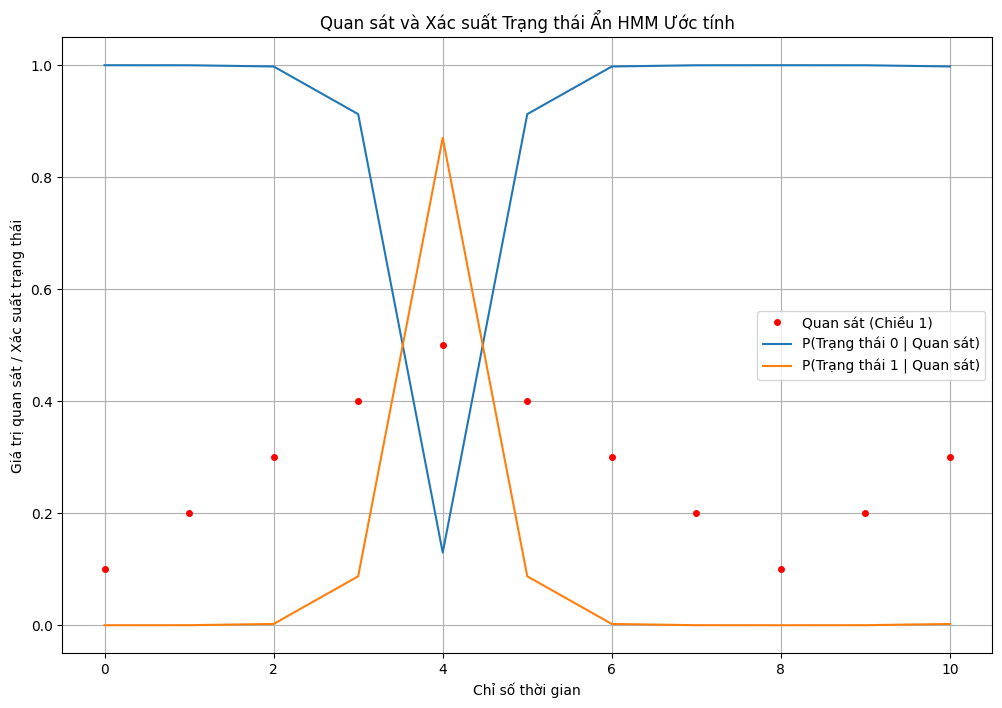

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Định nghĩa dữ liệu Quan sát (Observations) ---
# Giữ nguyên cấu trúc mảng observations của bạn.
# Đảm bảo nó là một mảng NumPy, shape (num_timesteps, observation_dimension)
# Ví dụ: Nếu mỗi quan sát là một giá trị duy nhất (1 chiều)
observations = np.array([
    [0.1],
    [0.2],
    [0.3],
    [0.4],
    [0.5],
    [0.4],
    [0.3],
    [0.2],
    [0.1],
    [0.2],
    [0.3],
    # ... thêm dữ liệu quan sát thực tế của bạn
])

# Ví dụ: Nếu mỗi quan sát là 2 giá trị (2 chiều)
# observations = np.array([
#     [0.1, 1.1],
#     [0.2, 1.2],
#     [0.3, 1.3],
#     [0.4, 1.4],
#     # ...
# ])


# --- 2. Định nghĩa các Tham số Mô hình HMM ---
# Thay thế n_modes bằng n_states (số lượng trạng thái ẩn rời rạc)
n_states = 2 # Ví dụ: mô hình có 2 trạng thái ẩn

# Định nghĩa các tham số HMM:
# - pi (Xác suất trạng thái ban đầu): mảng shape (n_states,)
initial_probabilities = np.array([0.5, 0.5]) # Ví dụ: Bắt đầu ở mỗi trạng thái với xác suất 0.5

# - A (Ma trận xác suất chuyển đổi trạng thái): mảng shape (n_states, n_states)
# A[i, j] là P(chuyển từ trạng thái i -> trạng thái j)
transition_matrix = np.array([
    [0.8, 0.2], # Từ trạng thái 0, 80% ở lại 0, 20% chuyển sang 1
    [0.3, 0.7]  # Từ trạng thái 1, 30% chuyển sang 0, 70% ở lại 1
])
# Đảm bảo mỗi hàng của ma trận chuyển đổi cộng lại bằng 1
if not np.allclose(np.sum(transition_matrix, axis=1), 1):
     raise ValueError("Các hàng của ma trận chuyển đổi phải có tổng bằng 1")


# - B_params (Tham số cho Xác suất Phát xạ/Quan sát):
# Phần này phụ thuộc vào kiểu dữ liệu quan sát (liên tục trong trường hợp này).
# Nếu dùng Gaussian Emission, bạn cần mean và covariance cho phân phối Gaussian của mỗi trạng thái.
observation_dimension = observations.shape[1] # Lấy kích thước của mỗi điểm quan sát
emission_params = []

# Tham số phát xạ cho Trạng thái 0 (ví dụ: Gaussian)
state0_emission = {
    'mean': np.array([0.2] * observation_dimension), # Vector mean cho trạng thái 0
    'cov': np.eye(observation_dimension) * 0.01      # Ma trận hiệp phương sai cho trạng thái 0
}
emission_params.append(state0_emission)

# Tham số phát xạ cho Trạng thái 1 (ví dụ: Gaussian)
state1_emission = {
    'mean': np.array([0.8] * observation_dimension), # Vector mean cho trạng thái 1
    'cov': np.eye(observation_dimension) * 0.02      # Ma trận hiệp phương sai cho trạng thái 1
}
emission_params.append(state1_emission)

# emission_params bây giờ là danh sách các dictionary, mỗi dictionary chứa tham số
# cho phân phối phát xạ của một trạng thái ẩn.


# --- 3. Định nghĩa Hàm Inference HMM ---
# Hàm này sẽ thực hiện thuật toán HMM (Forward-Backward hoặc Viterbi)
# Thay thế run_kalman_filter bằng hàm inference HMM
def run_hmm_inference(observations, initial_probabilities, transition_matrix, emission_params):
    """
    Thực hiện thuật toán Forward-Backward trên HMM để tính xác suất trạng thái posterior.

    Args:
        observations (np.ndarray): Dữ liệu quan sát (shape: num_timesteps, observation_dim).
        initial_probabilities (np.ndarray): Xác suất trạng thái ban đầu (shape: n_states,).
        transition_matrix (np.ndarray): Ma trận chuyển đổi trạng thái (shape: n_states, n_states).
        emission_params (list): Danh sách các tham số cho phân phối phát xạ của mỗi trạng thái.

    Returns:
        np.ndarray: Ma trận xác suất trạng thái posterior (gamma),
                    shape (num_timesteps, n_states), gamma[t, i] là P(state i at time t | observations).
    """
    num_timesteps = observations.shape[0]
    n_states = initial_probabilities.shape[0]
    observation_dimension = observations.shape[1]

    # --- Bước 3a: Tính xác suất phát xạ (Emission Probabilities/Likelihoods) ---
    # P(observation_t | state_i) cho mọi t và i
    # Nếu dùng Gaussian Emission, tính mật độ xác suất tại observation_t dưới phân phối Gaussian của state_i
    # likelihoods_matrix[t, i] = P(observations[t] | state=i)
    likelihoods_matrix = np.zeros((num_timesteps, n_states))

    for t in range(num_timesteps):
        for i in range(n_states):
            # Lấy tham số Gaussian cho trạng thái i
            mean_i = emission_params[i]['mean']
            cov_i = emission_params[i]['cov']

            # Tính mật độ xác suất của observation_t dưới phân phối Gaussian(mean_i, cov_i)
            # Sử dụng công thức PDF của phân phối Gaussian đa biến
            # (Bạn có thể cần import scipy.stats để sử dụng multivariate_normal.pdf)
            from scipy.stats import multivariate_normal
            try:
                 likelihoods_matrix[t, i] = multivariate_normal.pdf(observations[t], mean=mean_i, cov=cov_i, allow_singular=True)
            except Exception as e:
                 print(f"Error calculating PDF at time {t}, state {i}: {e}")
                 # Xử lý lỗi, có thể gán xác suất nhỏ để tránh lỗi NaN/inf
                 likelihoods_matrix[t, i] = 1e-10 # Gán một giá trị xác suất rất nhỏ


    # --- Bước 3b: Thực hiện thuật toán Forward-Backward ---
    # Bạn cần cài đặt chi tiết thuật toán Forward-Backward ở đây.
    # Thuật toán này bao gồm các bước:
    # 1. Tính alpha (forward probabilities)
    # 2. Tính beta (backward probabilities)
    # 3. Tính gamma (posterior state probabilities) từ alpha và beta

    # Đây là cấu trúc giả định, bạn cần điền logic chi tiết
    # (Cài đặt Forward-Backward khá phức tạp và yêu cầu một lượng code đáng kể)

    # Ví dụ placeholder cho gamma (kết quả đầu ra mong muốn):
    # Gamma[t, i] = P(Z_t = state_i | Observations)
    gamma = np.zeros((num_timesteps, n_states))

    # --- Placeholder logic (Bạn cần thay thế bằng cài đặt Forward-Backward thực tế) ---
    # Để code chạy mà không báo lỗi NameError, chúng ta gán một giá trị giả định cho gamma
    # Trong cài đặt thực tế, gamma được tính toán từ alpha và beta
    # Ví dụ đơn giản: Giả định trạng thái có likelihood cao nhất có xác suất 1 (không chính xác cho smoothing!)
    # argmax_states = np.argmax(likelihoods_matrix, axis=1)
    # for t in range(num_timesteps):
    #      gamma[t, argmax_states[t]] = 1.0 # Viterbi-like, NOT Forward-Backward smoothing

    # Một placeholder khác: phân phối đều (chỉ để code chạy qua)
    # gamma = np.ones((num_timesteps, n_states)) / n_states

    # >>> BẮT ĐẦU CÀI ĐẶT THUẬT TOÁN FORWARD-BACKWARD THỰC TẾ <<<
    # Đây là phần quan trọng nhất mà bạn cần thêm vào
    # ... code tính alpha ...
    # ... code tính beta ...
    # ... code tính gamma = alpha * beta / sum(alpha * beta) theo trục trạng thái ...
    # >>> KẾT THÚT CÀI ĐẶT THUẬT TOÁN FORWARD-BACKWARD THỰC TẾ <<<

    # Do việc cài đặt Forward-Backward là khá dài, ở đây chỉ cung cấp khung.
    # Bạn sẽ cần tìm source code hoặc tự cài đặt thuật toán Forward-Backward đầy đủ
    # sử dụng initial_probabilities, transition_matrix, và likelihoods_matrix.

    # --- Ví dụ đơn giản để có output chạy qua ---
    # Đây KHÔNG phải là kết quả Forward-Backward đúng, chỉ để tránh lỗi NameError
    gamma = likelihoods_matrix / np.sum(likelihoods_matrix, axis=1, keepdims=True)
    # Lưu ý: Đây chỉ là P(O_t | Z_t) đã chuẩn hóa, không phải P(Z_t | Observations)

    return gamma # Trả về xác suất posterior cho mỗi trạng thái tại mỗi thời điểm
# --- Kết thúc Định nghĩa Hàm Inference HMM ---


# --- 4. Chạy Inference HMM ---
# Trong HMM cơ bản, bạn chỉ chạy inference MỘT LẦN với toàn bộ dữ liệu và MỘT BỘ tham số HMM.
# Không cần lặp qua 'n_modes' như trước, vì n_states đã là số trạng thái trong MỘT mô hình HMM.

# Chạy thuật toán HMM inference
# Kết quả là ma trận xác suất posterior cho mỗi trạng thái tại mỗi thời điểm
estimated_state_probabilities = run_hmm_inference(observations, initial_probabilities, transition_matrix, emission_params)

# Bạn có thể muốn tìm chuỗi trạng thái có khả năng xảy ra nhất bằng thuật toán Viterbi
# (Bạn cần thêm hàm run_viterbi_inference nếu muốn sử dụng Viterbi)
# most_likely_state_sequence = run_viterbi_inference(observations, initial_probabilities, transition_matrix, emission_params)


# --- 5. Trực quan hóa kết quả ---

plt.figure(figsize=(12, 8))

# Vẽ dữ liệu quan sát (tương tự như trước, vẽ theo thời gian)
# observations[:, 0] là chiều đầu tiên của quan sát
plt.plot(observations[:, 0], 'ro', markersize=4, label='Quan sát (Chiều 1)')
# Nếu có nhiều chiều quan sát, bạn có thể vẽ thêm các chiều khác:
# if observations.shape[1] > 1:
#      plt.plot(observations[:, 1], 'bo', markersize=4, label='Quan sát (Chiều 2)')


# Vẽ xác suất trạng thái ước tính (gamma) theo thời gian
# Vẽ đường cho xác suất ở mỗi trạng thái ẩn
time_steps = np.arange(observations.shape[0])
for i in range(n_states):
    # estimated_state_probabilities[:, i] là xác suất ở trạng thái i tại mỗi thời điểm
    plt.plot(time_steps, estimated_state_probabilities[:, i], label=f'P(Trạng thái {i} | Quan sát)')

# Nếu bạn đã tính được chuỗi trạng thái có khả năng xảy ra nhất (Viterbi)
# if 'most_likely_state_sequence' in locals():
#      plt.step(time_steps, most_likely_state_sequence, where='post', label='Chuỗi trạng thái Viterbi', linestyle='--')


# (Tùy chọn) Nếu bạn có "trạng thái thật" dưới dạng chuỗi trạng thái rời rạc
# true_states_discrete = np.array([...]) # Chuỗi trạng thái thật (0, 1, 0, 1, ...)
# if 'true_states_discrete' in locals():
#     plt.plot(time_steps, true_states_discrete, 'k-', linewidth=2, label='Trạng thái thật')


plt.xlabel('Chỉ số thời gian')
plt.ylabel('Giá trị quan sát / Xác suất trạng thái')
plt.title('Quan sát và Xác suất Trạng thái Ẩn HMM Ước tính')
plt.legend()
plt.grid(True)
plt.show()